### Reference
* https://arxiv.org/abs/1606.07792
* https://grouplens.org/datasets/movielens/1m/
* https://keras.io/examples/structured_data/wide_deep_cross_networks/
* https://github.com/floraxhuang/Movie-Recommendation-System/blob/master/Deep%20and%20Wide%20Model.ipynb


In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import tensorflow as tf
import random

In [2]:
BATCH_SIZE = 1024
NUM_EPOCHS = 50

### [Option] download MovieLens 1M dataset

In [ ]:
import os
import wget
import zipfile

dirPath = '../dataset'
zipFilePath = os.path.join(dirPath, 'ml-1m.zip')
remoteRrl = 'https://files.grouplens.org/datasets/movielens/ml-1m.zip'

if not os.path.exists(dirPath):
    os.makedirs(dirPath)
    
# download
wget.download(remoteRrl, zipFilePath)

# unzip files
with zipfile.ZipFile(zipFilePath, 'r') as zipRef:
    zipRef.extractall(dirPath)

## load dataset

In [3]:
df_ratings = pd.read_csv('../dataset/ml-1m/ratings.dat', sep='::', engine='python', names=['UserID', 'MovieID', 'Rating', 'Timestamp'], header=None)
df_movies = pd.read_csv('../dataset/ml-1m/movies.dat', sep='::', engine='python', names=['MovieID', 'Title', 'Genres'], header=None)
df_users = pd.read_csv('../dataset/ml-1m/users.dat', sep='::', engine='python', names=['UserID', 'Gender', 'Age', 'Occupation', 'ZipCode'], header=None)

# numOfUsers = df_ratings.UserID.nunique()
# numOfItems = df_ratings.MovieID.nunique()

In [4]:
# preprocessing
df_movies['Genres'] = df_movies.apply(lambda row : row['Genres'].split("|")[0], axis=1)
df_movies['MovieYear'] = df_movies.apply(lambda row : int(row['Title'].split("(")[-1][:-1]),axis=1)

age_bins = [0, 15, 25, 45, 100]
age_labels = [i for i in range(len(age_bins) - 1)]
df_users['Age'] = pd.cut(df_users['Age'], age_bins, labels=age_labels)
df_users['Gender'].replace({'F':0,'M':1}, inplace=True)

df_total = pd.merge(df_ratings, df_movies, how='left', on="MovieID")
df_total = pd.merge(df_total, df_users, how='left', on="UserID")
df_total.drop(['Title'], axis=1, inplace=True)
df_total.drop(['ZipCode'], axis=1, inplace=True)
df_total.drop(['Timestamp'], axis=1, inplace=True)

# Normalize rating in [0, 1]
for feature_name in ['Rating', 'MovieYear']:
    ratings = df_total[feature_name].values.astype(np.float)
    scaledRatings = (ratings - min(ratings)) / (max(ratings) - min(ratings))
    df_total[feature_name] = pd.DataFrame(scaledRatings)

In [5]:
df_total.head()

,UserID,MovieID,Rating,Genres,MovieYear,Gender,Age,Occupation
0,1,1193,1.00,Drama,0.691358,0,0,10
1,1,661,0.50,Animation,0.950617,0,0,10
2,1,914,0.50,Musical,0.555556,0,0,10
3,1,3408,0.75,Drama,1.000000,0,0,10
4,1,2355,1.00,Animation,0.975309,0,0,10


In [6]:
idx2name = defaultdict(dict)
# for col_name in df_total.select_dtypes(include=['object']).columns:
for col_name in ['UserID', 'MovieID', 'Genres', 'Gender', 'Occupation']:
    idx2name[col_name] = dict(enumerate(list(df_total[col_name].astype('category').cat.categories)))
    df_total[col_name] = df_total[col_name].astype('category').cat.codes # convert categories to numbers

In [7]:
df_total.head()

,UserID,MovieID,Rating,Genres,MovieYear,Gender,Age,Occupation
0,0,1104,1.00,7,0.691358,0,0,10
1,0,639,0.50,2,0.950617,0,0,10
2,0,853,0.50,11,0.555556,0,0,10
3,0,3177,0.75,7,1.000000,0,0,10
4,0,2162,1.00,2,0.975309,0,0,10


## build dataset

In [8]:
wide_cols = ['UserID', 'MovieID', 'MovieYear', 'Gender', 'Age', 'Occupation']
embeddings_cols = {'UserID': 32, 'MovieID': 32, 'Genres': 2}
# continuous_cols = ['MovieYear', 'Gender', 'Age', 'Occupation']
continuous_cols = ['MovieYear', 'Age']
deep_cols = list(embeddings_cols.keys()) + continuous_cols
feature_cols = list(set(wide_cols + deep_cols))
# crosses_cols = ()
target_name = 'Rating'

In [9]:
def get_dataset(df_total, wide_cols, deep_cols):
    numOfSamples = df_total.shape[0]
    numOfTrainSet = int(numOfSamples * 0.7)
    numOfValidSet = int(numOfSamples * 0.15)
    numOfTestSet = numOfSamples - numOfTrainSet - numOfValidSet

    df_shuffled = df_total.sample(frac=1)
    features_dict = {}
    for feature_name in feature_cols:
        features_dict[feature_name] = df_total[feature_name].values.astype(np.float32)
    target = df_shuffled[target_name].values.astype(np.float32)
    
    dataset_total = tf.data.Dataset.from_tensor_slices((features_dict, target))
    del features_dict, target

    dataset_train = dataset_total.take(numOfTrainSet)
    dataset_total.skip(numOfTrainSet)
    dataset_valid = dataset_total.take(numOfValidSet)
    dataset_total.skip(numOfValidSet)
    dataset_test = dataset_total.take(numOfTestSet)
    del dataset_total
    
    dataset_train = dataset_train.shuffle(buffer_size=BATCH_SIZE*8).batch(BATCH_SIZE)
    dataset_valid = dataset_valid.batch(BATCH_SIZE)
    dataset_test = dataset_test.batch(BATCH_SIZE)
    return dataset_train, dataset_valid, dataset_test

dataset_train, dataset_valid, dataset_test = get_dataset(df_total, wide_cols, deep_cols)

## build model

In [10]:
def get_model_inputs(feature_cols, name):
    inputs = {}
    encoded_inputs = {}
    for feature_name in feature_cols:
        #if 1:
        if feature_name in continuous_cols:
            raw_input = tf.keras.Input(shape=(), dtype=tf.float32, name=f'{name}/numeric_{feature_name}')
            encoded_input = tf.keras.layers.Reshape(target_shape=(1,), name=f'{name}/reshape_{feature_name}') (raw_input)
            inputs[feature_name] = raw_input
            encoded_inputs[feature_name] = encoded_input
        else:
            # define input dimension
            input_dim = len(idx2name[feature_name])
            # define output dimension
            if feature_name in embeddings_cols:                
                output_dim = embeddings_cols[feature_name]
            else:
                output_dim = input_dim
            raw_input = tf.keras.Input(shape=(), dtype=tf.float32, name=f'{name}/categorical_{feature_name}')
            encoded_input = tf.keras.layers.Embedding(input_dim, output_dim, name=f'{name}/embedding_{feature_name}') (raw_input)
            inputs[feature_name] = raw_input
            encoded_inputs[feature_name] = encoded_input
    return inputs, encoded_inputs

In [11]:
def create_model(model_name='model'):
    inputs, encoded_inputs = get_model_inputs(feature_cols, model_name)
    features = tf.keras.layers.concatenate(encoded_inputs.values(), name=f'{model_name}/concatenate_1')
    deep_features = features
    
    for idx, units in enumerate([32, 16]):
        deep_features = tf.keras.layers.Dense(units=units, activation='relu', name=f'{model_name}/dense_{idx}') (deep_features)
    
    features = tf.keras.layers.concatenate([features, deep_features], name=f'{model_name}/concatenate_2')
    outputs = tf.keras.layers.Dense(units=1, activation='sigmoid', name=f'{model_name}/output') (features)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    return model

In [12]:
model = create_model()

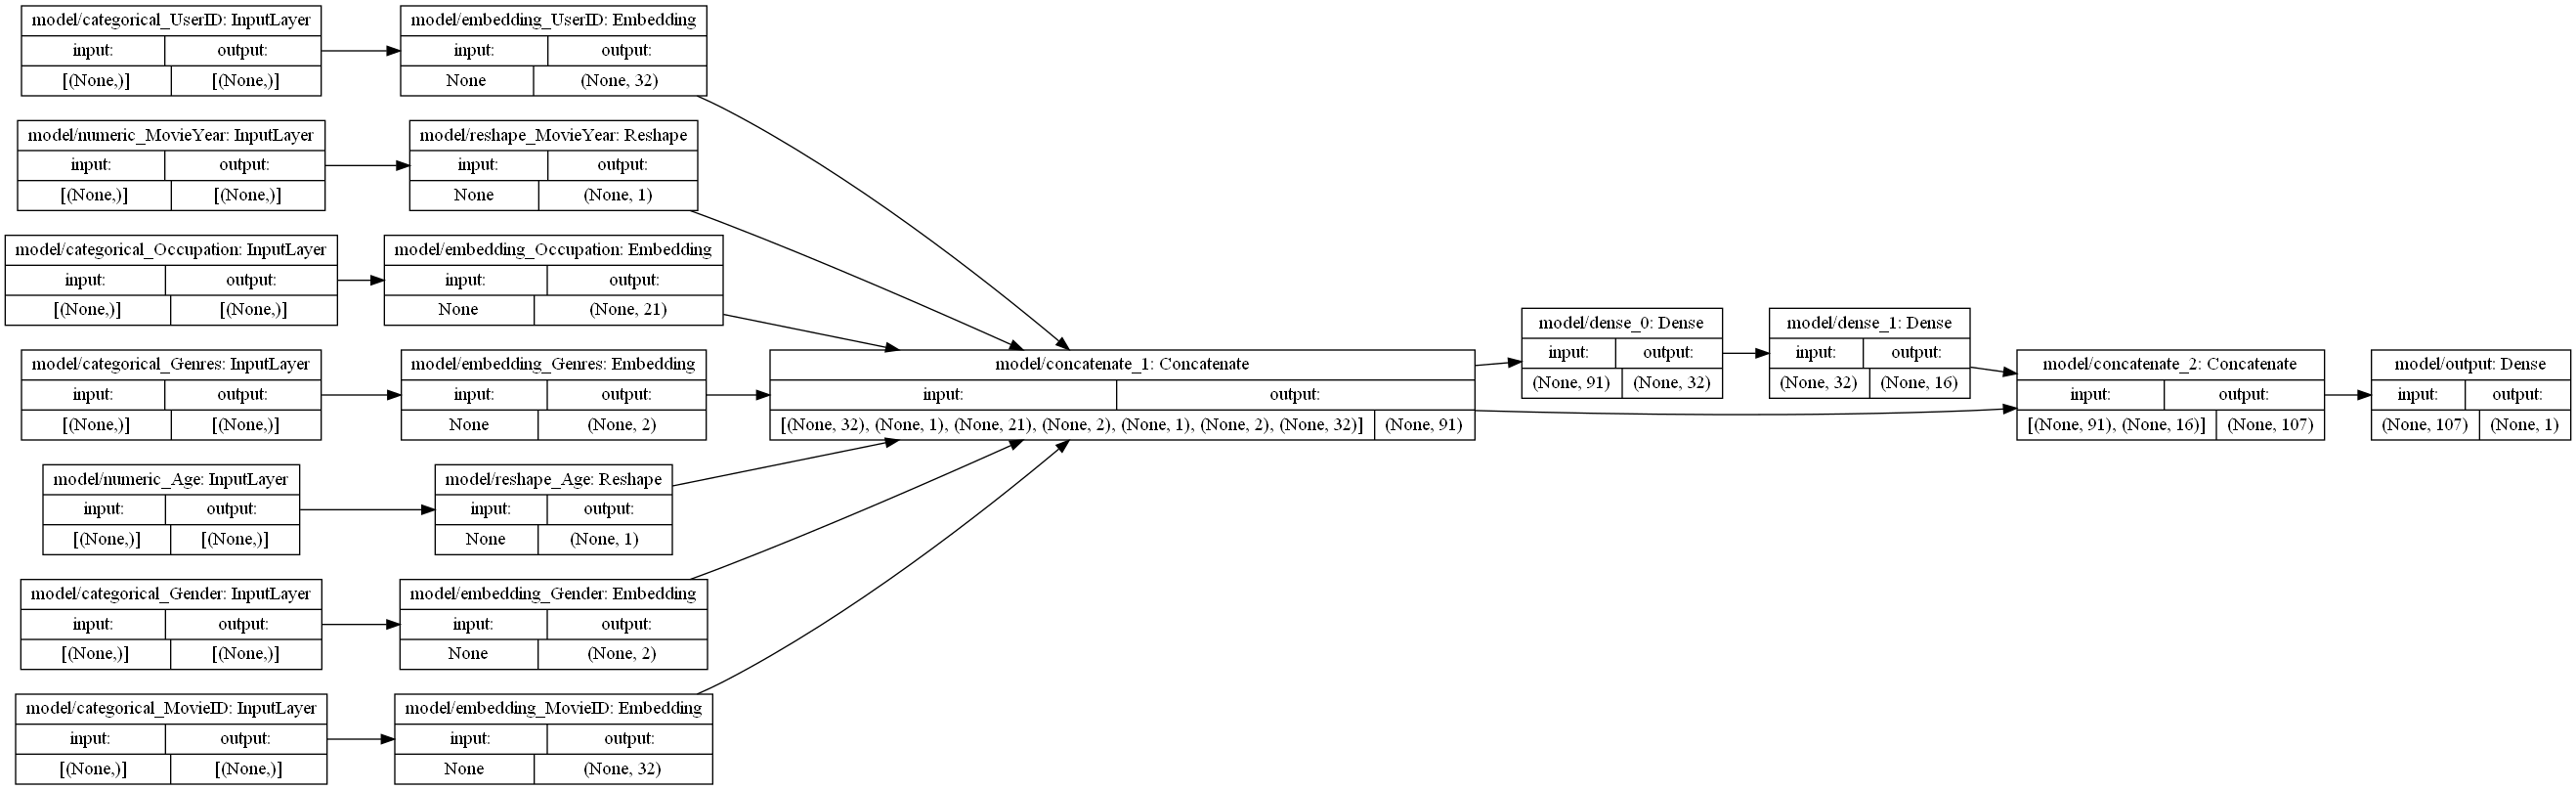

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='LR', to_file='./images/model.png')

## training

In [14]:
# optimizer
#optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
#optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1)

def getLoss(pred, gt):
    gt = tf.expand_dims(gt, axis=-1)
    #loss = tf.reduce_mean(tf.pow(pred - gt, 2))
    loss = tf.sqrt(tf.reduce_mean(tf.abs(pred - gt)))
    return loss

In [15]:
# training with tf.GradientTape

from collections import defaultdict

records = defaultdict(list)
for epoch in range(NUM_EPOCHS):
    
    for step, (features, gt) in enumerate(dataset_train):
        with tf.GradientTape() as tape:
            pred = model(features, training=True)
            loss = getLoss(pred=pred, gt=gt)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        if step % 50 == 0:
            print(f'step={step}, loss={loss.numpy()}')
        if step % 5 == 0:            
            records['train_loss'].append(loss.numpy())
            
        if step == 500: break
    
    break

step=0, loss=0.4967390298843384
step=50, loss=0.48601457476615906
step=100, loss=0.47295865416526794
step=150, loss=0.4689783751964569
step=200, loss=0.45923861861228943
step=250, loss=0.4627079665660858
step=300, loss=0.47664615511894226
step=350, loss=0.4668205976486206
step=400, loss=0.4727344214916229
step=450, loss=0.46821096539497375
step=500, loss=0.45183834433555603


#### The result is not very good, it seems that better data pre-processing or hyperparameters may be needed

Text(0.5, 0, 'Time(for each 10 steps)')

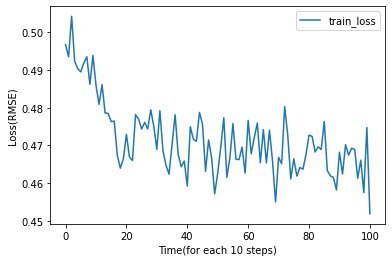

In [16]:
import matplotlib.pyplot as plt

plt.plot(records['train_loss'], label='train_loss')
plt.legend()
plt.ylabel('Loss(RMSE)')
plt.xlabel('Time(for each 10 steps)')